# Unsupervised Learning with Vox Politics

For this capstone I am going to cluster authors just by looking at the articles they have written. For this task I found a data set that contains many articles from the news website Vox. You can see the data set for yourself here: [Vox Articles on data.world](https://data.world/elenadata/vox-articles). Using only the main body text of these articles, I would like to create a model that tries to predict the authors of each article. For this to be more challenging, I will also only use articles that have been categorized as "Politics & Policy" so that the contents are generally similar. Through this project I will show my ability to use unsupervised and supervised algorithms, while also unpackaging what their outputs can tell us. Through this I will explore the benefits and challenges you encounter with each method.

Since I have already proven my abilities with supervised learning [in my supervised learning capstone where I perform sentiment analysis on Amazon reviews](https://github.com/TheGregArayaSet/Sentiment-Analysis-on-Amazon-Reviews), I would like to focus on unsupervised learning methods to create groups first. I'll start off using the common K-Means algorithm, followed by Spectral Clustering, and then Mean-Shift. Afterwards, I will also run a Support Vector Classification model to compare against. Since we are aware ahead of time how many authors we are trying to predict, the SVC will probably perform somewhat better in terms of predicting the authors outright, but I'm hoping that we can also show an interesting relationship between authors through the combination of all of these models' output information. So, let's begin by importing all the necessary modules and taking a look at our data.

In [87]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

# Modules for making the model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Data cleaning and feature importance
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import RandomizedSearchCV

# K-Means module
from sklearn.cluster import KMeans

# Spectral Clustering module
from sklearn.cluster import SpectralClustering

# Mean Shift modules
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import FunctionTransformer

# Metrics to evaluate models
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
from sklearn.metrics import classification_report

# Support Vector Classification
from sklearn.svm import LinearSVC
import warnings

Now that we have all the modules we'll be using, lets take a look at the data from Vox.

In [2]:
# Read in the full TSV file
raw_df = pd.read_csv('dsjVoxArticles.tsv', sep='\t', header=0)

# Take a look at it
raw_df.head()

,title,author,category,published_date,updated_on,slug,blurb,body
0,Bitcoin is down 60 percent this year. Here's w...,Timothy B. Lee,Business & Finance,2014-03-31 14:01:30,2014-12-16 16:37:36,http://www.vox.com/2014/3/31/5557170/bitcoin-b...,Bitcoins have lost more than 60 percent of the...,<p>The markets haven't been kind to<span> </sp...
1,6 health problems marijuana could treat better...,German Lopez,War on Drugs,2014-03-31 15:44:21,2014-11-17 00:20:33,http://www.vox.com/2014/3/31/5557700/six-probl...,Medical marijuana could fill gaps that current...,<p>Twenty states have so far legalized the med...
2,9 charts that explain the history of global we...,Matthew Yglesias,Business & Finance,2014-04-10 13:30:01,2014-12-16 15:47:02,http://www.vox.com/2014/4/10/5561608/9-charts-...,These nine charts from Thomas Piketty's new bo...,<p>Thomas Piketty's book <i>Capital in the 21s...
3,Remember when legal marijuana was going to sen...,German Lopez,Criminal Justice,2014-04-03 23:25:55,2014-05-06 21:58:42,http://www.vox.com/2014/4/3/5563134/marijuana-...,"Three months after legalizing marijuana, Denve...",<p><span>When Colorado legalized recreational ...
4,Obamacare succeeded for one simple reason: it'...,Sarah Kliff,Health Care,2014-04-01 20:26:14,2014-11-18 15:09:14,http://www.vox.com/2014/4/1/5570780/the-two-re...,"After a catastrophic launch, Obamacare still s...",<p>There's a very simple reason that Obamacare...


Looks like we have some good information here. The title, the author, what the category of the article is, as well as a summary and the full body of the text (with some html code throughout it). This will certainly meet my basic requirements. Let's find the top 10 authors in the Politics & Policy category and put them in their own dataframe to build our models off of.

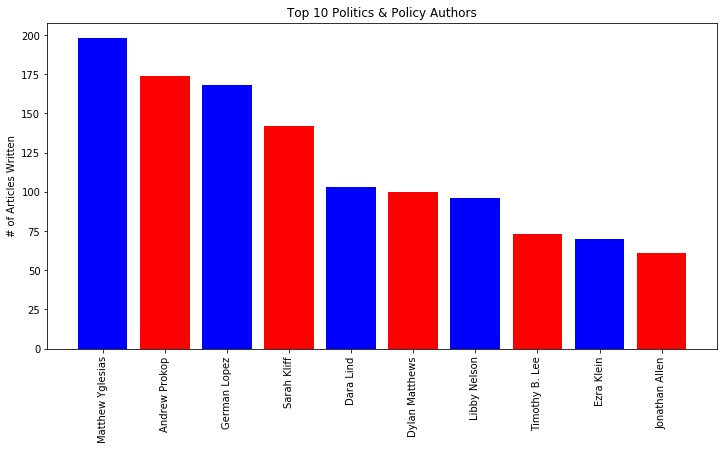


 Total number of articles by the top 10: 1185


In [3]:
# Take just the politics and policy articles
main_df = raw_df[raw_df['category'] == 'Politics & Policy']

# Take the top ten authors from that list and their article counts
top10 = main_df.author.value_counts()[:10]

# Plot the top ten on a bar graph
plt.figure(figsize = (12,6))
plt.bar(top10.index, height=top10.values, align='center', color=['blue', 'red'])
plt.xticks(rotation='vertical')
plt.title("Top 10 Politics & Policy Authors")
plt.ylabel('# of Articles Written')
plt.show()

print('\n', "Total number of articles by the top 10:", top10.sum())

Now we can make a dataframe with just our top 10 authors, and the main body of their articles. We'll also have to clean the text of all the html code that was picked up when the data was scraped.

In [4]:
# Make a list from the names of the top 10 and take their works for a new dataframe
t10_list = top10.keys()

top10_df = main_df[main_df['author'].isin(t10_list)].copy()

# Take all of the html coding out of the "body" column using beautiful soup
top10_df['body'] = [BeautifulSoup(body).get_text() for body in top10_df['body']]

# Drop the columns I won't need
top10_df = top10_df[['author', 'body']]

# Take a look at it
top10_df.head()

,author,body
21,Matthew Yglesias,Patricia Arquette's speech about the gender pa...
53,Andrew Prokop,Who really matters in our democracy — the gene...
141,Andrew Prokop,We've written about gerrymandering here on Vox...
193,Ezra Klein,Presidents consistently overpromise and underd...
209,Dylan Matthews,Let's imagine Daniel and Henry are vacationing...


Since our first two models require uniform sizes of clusters, we will just take the first 61 articles from each of these authors. This still leaves us with 610 total articles, so that should hopefully serve our purposes.

In [5]:
# Group by author, take 61 values, drop any that we don't need and reset the index, then copy it so we don't get warnings
top10_unif_df = top10_df.groupby(['author']).head(61).reset_index(drop=True).copy()

Now let's make sure we aren't missing any fields before we dive into the models.

In [6]:
# Make sure we aren't missing any fields
top10_unif_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 21 to 10650
Data columns (total 2 columns):
author    610 non-null object
body      610 non-null object
dtypes: object(2)
memory usage: 14.3+ KB


Now that we're certain our data is ready to use, we can create our variables. Following that we can start building and testing out our models.

In [67]:
# Assign our feature column
X = top10_unif_df.body

# Assign our target column
Y = top10_unif_df.author

## K-Means Model

Since we know there are 10 authors, and this model requires an input number of clusters, this is a logical model to start with. It also tends to run quickly and that will be helpful as we test our ideas. For this initial run I tried a variety of combinations for a few of the arguments within the functions. I chose to use an ngram_range of 2 for the TfidfVectorizer so that it would look at combinations of two words along with just the words themselves (for example it would count up the number of times "not", "great", and "not great" are all found). I tried using larger n_gram ranges, but they didn't improve performance very much and greatly increased time to run. I also told this vectorizer to get rid of useless stop words in the English language, such as "the", "for", "and", etc. For the "n_init" argument, which tells the K-Means function the number of times the algorithm should be run with different centroid seeds, I tried a range of #s from 10 to 100 and found 60 performed the best. I also gave K-Means 10 clusters in "n_clusters" so that we could hopefully find our 10 authors accurately.

In [61]:
# Start a timer
km_start = time.time()

# Instantiate our vectorizer, include bi-grams, and exclude useless stop words
km_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# Extract features from our dataset
X_km = km_vectorizer.fit_transform(X)

# Split our data up into 25/75 for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_km, Y, test_size=0.25, random_state = 42)

# Instantiate our clustering method
kmeans = KMeans(n_clusters = 10, n_init = 60)

# Fit the data
kmeans_model = kmeans.fit(X_train, y_train)

In [62]:
# Make predictions
kmeans_pred = kmeans_model.fit_predict(X_test, y_test)

# See how well it did
print("Adjusted Rand Index score:", metrics.adjusted_rand_score(y_test, kmeans_pred))
print("The K-Means model took", time.time() - km_start, "seconds")

Adjusted Rand Index score: 0.1290285433918623
The K-Means model took 608.6585247516632 seconds


Since the Adjusted Rand Index score is closer to zero than it is to 1, it looks like this model is close to predicting at random. That's no good! I wonder what the clusters look like, let's look at a contingency table.

In [63]:
# Get predicted clusters
pd.crosstab(y_test, kmeans_pred) 

col_0,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,
Andrew Prokop,0,0,1,10,1,1,4,1,0,18
Dara Lind,0,0,1,14,0,5,2,1,0,4
Dylan Matthews,2,1,2,2,2,1,1,1,0,11
Ezra Klein,0,0,1,1,7,0,0,4,0,3
German Lopez,3,0,2,0,14,0,8,0,5,8
Jonathan Allen,1,1,1,1,1,0,0,0,0,15
Libby Nelson,1,11,1,0,6,0,1,0,0,5
Matthew Yglesias,1,0,11,6,7,1,0,3,0,24
Sarah Kliff,0,0,4,1,33,0,0,0,0,2


This clearly didn't work out as well for us with 10 clusters, but maybe there's a reason for that. I'll try an interesting range of cluster sizes and see how they perform.

In [11]:
interesting_range = [4, 5, 8, 9, 11, 12, 14, 15, 20]

for nx in interesting_range:
    # Instantiate our clustering method
    kmeans = KMeans(n_clusters = nx, n_init = 60)

    # Fit the data
    kmeans_model = kmeans.fit(X_train, y_train)

    # Make predictions
    kmeans_pred = kmeans_model.fit_predict(X_test, y_test)

    # See how well it did
    print("The Adjusted Rand Index score using {} clusters is : {}".format(nx, metrics.adjusted_rand_score(y_test, kmeans_pred)))

The Adjusted Rand Index score using 4 clusters is : 0.06854323843426914
The Adjusted Rand Index score using 5 clusters is : 0.12421069780848354
The Adjusted Rand Index score using 8 clusters is : 0.13028772900253466
The Adjusted Rand Index score using 9 clusters is : 0.12774493723116817
The Adjusted Rand Index score using 11 clusters is : 0.14227973627165258
The Adjusted Rand Index score using 12 clusters is : 0.1395839474711459
The Adjusted Rand Index score using 14 clusters is : 0.1781061874137374
The Adjusted Rand Index score using 15 clusters is : 0.20278719000640466
The Adjusted Rand Index score using 20 clusters is : 0.24410451086524743


Looks like 15 and 20 clusters did well in comparison. Let's see what their contingency tables look like to get some insight.

In [34]:
for nx in [15, 20]:
    # Instantiate our clustering method
    kmeans = KMeans(n_clusters = nx, n_init = 60)

    # Fit the data
    kmeans_model = kmeans.fit(X_train, y_train)

    # Make predictions
    kmeans_pred = kmeans_model.fit_predict(X_test, y_test)

    # See how well it did
    print("The Contingency Table using {} clusters:".format(nx))
    print(pd.crosstab(y_test, kmeans_pred), '\n')

The Contingency Table using 15 clusters:
col_0             0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
author                                                                      
Andrew Prokop      2   9   0   3   3   2   0   0   0   0   3   0   0   1   0
Dara Lind          0   4   0   1   0   6   0   0   5   0   0   2   0   0   0
Dylan Matthews     0   3   0   0   1   0   0   0   0   0   3   0   0   2   0
Ezra Klein         0   2   0   3   1   0   0   1   0   2   2   0   0   2   0
German Lopez       0   0   4   0   3   0   0   1   1   0   5   0   2   0   1
Jonathan Allen     0  11   0   1   0   0   0   0   0   1   6   0   0   0   0
Libby Nelson       0   2   0   0   0   2   7   0   2   1   0   0   0   1   0
Matthew Yglesias   0   2   0   3   0   0   1   1   0   1   0   0   0   5   0
Sarah Kliff        0   0   1   0   1   1   0  10   0   0   2   0   0   1   0
Timothy B. Lee     0   2   0   0   0   0   0   0   1   3   1   0   2   0   1 

The Contingency Table using 20 cl

These had varied results, however these groupings could still tell us something. For example, Libby Nelson consistently stands out. In the cluster of 10 she gets 11 articles in one group while there are only 2 other articles in that group (see column 2), with 15 clusters she almost got a whole cluster to herself with 7 articles (see column 6), and in the 20 cluster table she consisted of 9/13 articles in the 6th cluster. I also noticed that Dara Lind and Sarah Kliff were able to conquer a few clusters for themselves in each of our tests. It's possible that some people have pretty distinct styles of writing, while others tend to go with the safe and normal flow. Especially in this time of hyper political correctness, the editing process is probably quite restricting. However, unfortunately none of the chosen cluster sizes did all that much better than above. Maybe we should try and look at another model.

## Spectral Clustering Model

As we can again provide the number of clusters we expect to spectral clustering, let's see how this algorithm performs with 10 groups. I tried multiple ngram_range values for the TfidfVectorizer, like above, but it didn't increase accuracy all that much and greatly increased time to run. As for the Spectral Clustering parameters themselves, I simply tried a range of combinations of the variables that you see and kept the rest at their defaults. I did this by running the 10 clusters over and over and keeping a separate spreadsheet where I recorded values and reran it. This allowed me to learn a bit about how each variable works. I didn't want to include all of the combinations in this report as it would just end up being really long, and uninformative for the experienced reader. This process is most likely less interesting than the actual results anyways, so let's dive in.

In [74]:
# Start a timer
sc_start = time.time()

# Instantiate our vectorizer, include bi-grams, and exclude useless stop words
sc_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# Extract features from our dataset
X_sc = sc_vectorizer.fit_transform(X)

# Split our data up into 25/75 for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_sc, Y, test_size=0.25, random_state = 42)

# Instantiate our clustering method
spect_clust = SpectralClustering(n_clusters=10, eigen_solver = None, n_init = 10, assign_labels = 'discretize')

# Fit the data
sc_model = spect_clust.fit(X_train, y_train)

In [75]:
# Make predictions
sc_pred = sc_model.fit_predict(X_test, y_test)

# See how well it did
print("Adjusted Rand Index score:", metrics.adjusted_rand_score(y_test, sc_pred))
print("The Spectral Clustering model took", time.time() - sc_start, "seconds")

Adjusted Rand Index score: 0.1782984424287866
The Spectral Clustering model took 1.7532403469085693 seconds


That seems to not have done so well either. Well, let's take a look at how the clusters were predicted in this case.

In [76]:
# Get predicted clusters
pd.crosstab(y_test, sc_pred) 

col_0,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,
Andrew Prokop,8,2,0,2,0,0,10,1,0,0
Dara Lind,2,0,15,0,0,0,1,0,0,0
Dylan Matthews,2,2,1,0,0,0,3,1,0,0
Ezra Klein,3,1,1,0,0,0,3,3,2,0
German Lopez,0,3,0,0,0,2,6,1,0,5
Jonathan Allen,15,0,0,0,0,0,1,0,1,2
Libby Nelson,0,0,0,0,5,0,10,0,0,0
Matthew Yglesias,1,3,0,0,0,0,8,1,0,0
Sarah Kliff,0,1,0,0,0,0,5,10,0,0


Though this didn't do so well, it looks like Libby Nelson got a column to herself again (see column 4). Dara Lind and Sarah Kliff also seemed to get clustered quite well too. Let's try a range of clusters again like we did for K-Means, maybe we can find an ideal grouping or two to try that can give us further insight.

In [16]:
for nx in interesting_range:
    # Instantiate our clustering method
    spect_clust = SpectralClustering(n_clusters=nx, eigen_solver = None, n_init = 10, assign_labels = 'discretize')

    # Fit the data
    sc_model = spect_clust.fit(X_train, y_train)

    # Make predictions
    sc_pred = sc_model.fit_predict(X_test, y_test)

    # See how well it did
    sent = "The Adjusted Rand Index score using {} clusters is : {}"
    print(sent.format(nx, metrics.adjusted_rand_score(y_test, kmeans_pred)))

The Adjusted Rand Index score using 4 clusters is : 0.11404203717117059
The Adjusted Rand Index score using 5 clusters is : 0.11404203717117059
The Adjusted Rand Index score using 8 clusters is : 0.11404203717117059
The Adjusted Rand Index score using 9 clusters is : 0.11404203717117059
The Adjusted Rand Index score using 11 clusters is : 0.11404203717117059
The Adjusted Rand Index score using 12 clusters is : 0.11404203717117059
The Adjusted Rand Index score using 14 clusters is : 0.11404203717117059
The Adjusted Rand Index score using 15 clusters is : 0.11404203717117059
The Adjusted Rand Index score using 20 clusters is : 0.11404203717117059


Well seeing as how these all got the same score for each of these cluster values, we probably won't get much more out of this model, let's try something else.

## Mean-Shift Model

I decided to try a mean-shift model next because in theory it should work for this data, since the clusters aren't necessarily the same size. Since we don't need uniform sizes for the clusters, we can go back to the full data with > 1000 articles.

In [17]:
# Assign our feature column
X = top10_df.body

# Assign our target column
Y = top10_df.author

In [18]:
# Start a timer
ms_start = time.time()

# Instantiate our vectorizer, include bi-grams, and exclude useless stop words
ms_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# Extract features from our dataset
X_ms = ms_vectorizer.fit_transform(X)

# Transform the sparse matrix of features into dense data so mean shift can use it
F = FunctionTransformer(lambda x: x.todense(), validate=False)
X_ms = F.transform(X_ms)

# Split our data up into 25/75 for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_ms, Y, test_size=0.25, random_state = 42)

# Instantiate our clustering method
mean_shift = MeanShift(bin_seeding = True, cluster_all = False)

# Fit the data
ms_model = mean_shift.fit(X_train, y_train)

In [19]:
# Make predictions
ms_pred = ms_model.fit_predict(X_test, y_test)

# See how well it did
print("Adjusted Rand Index score:", metrics.adjusted_rand_score(y_test, ms_pred))
print("The Mean Shift model took", time.time() - ms_start, "seconds")

Adjusted Rand Index score: 0.0
The Mean Shift model took 665.3452394008636 seconds


Seeing as how this model got a 0 Adjusted Rand Index score, there isn't any point in looking at the contingency table. What this tells us is that, most likely we don't have a varied enough data set. Essentially, it put everyone in the same group. It would probably be helpful if we pooled articles from different websites about the same topics, or just got more articles in general. Regardless, it is a telling sign, so I decided to keep this model in this write up even though it does so poorly.

### Support Vector Classification

Since we know for sure there should be 10 authors, we can try out a supervised learning model too. In my supervised learning capstone project, I had good recall and precision scores when using Support Vector Classification, so I'm going to try and see if I can guess the authors by their articles' contents. I will also be performing a Cross Validation search and a Pipeline in order to automate the steps that I was doing above, and to get the best parameters we can for this run. Let's dive in.

In [89]:
# Assign our feature column
X = top10_df.body

# Assign our target column
Y = top10_df.author

# Split up our training and testing data, 25/75
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [90]:
# Specify the distribution of parameters that we want to test
svc_prm_dist = dict(
    chi__k = [i for i in np.arange(100, 1_000, 100)],
    clf__loss = ['hinge', 'squared_hinge'],
    clf__C = [i for i in np.arange(0.1,1.1,0.1)],
    clf__fit_intercept = [True, False],
    clf__max_iter = [i for i in np.arange(8_500, 10_100, 100)]
    )

In [91]:
# Create a base pipeline that will take us through the modeling process
svc_base_pipeline = Pipeline([
    # Use TfidfVectorizer and ngram_range = (1,2) to choose 1 and/or 2 words at a time
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
    
    # Select the best features to train from using the chi squared algorithm
    ('chi', SelectKBest(chi2)),
    
    # Choose our classifier algorithm
    ('clf', LinearSVC(penalty = 'l2')) #'l2' is the standard in SVC
])

Now that we have a distribution of parameters that we want to try out, as well as a pipeline to push our work through, we can begin a cross validation search to find out best parameters. I chose a randomized search because it will be faster than doing a full grid search. NOTE: During this randomized search during some iterations the model is unable to converge and produces warnings, so I'm going to ignore any warnings just for this bit. The cross validation search does eventually converge and achieve what we need however so that's why it prints a warning instead of an error.

In [92]:
# Start a timer for the SVC's CV search
svccv_start_time = time.time()

# Temporarily blocks warnings
warnings.filterwarnings("ignore")

# Set up the random search with our parameter distribution
svc_rand_search = RandomizedSearchCV(svc_base_pipeline, svc_prm_dist, n_iter=20, cv=10, iid=False, verbose=0)

# Fit the random search to our data
svc_rand_search.fit(X_train, y_train)

In [93]:
print(svc_rand_search.best_params_)
print("The SVC's CV search took " + str(time.time() - svccv_start_time) + " seconds")

{'clf__max_iter': 9200, 'clf__loss': 'squared_hinge', 'clf__fit_intercept': False, 'clf__C': 0.9, 'chi__k': 800}
The SVC's CV search took 443.01765418052673 seconds


Now that we have found our optimal parameters and printed them out above, let's plug them into another pipeline and get some descriptive statistics about each author. We will achieve this by looking at a classification report.

In [94]:
# Assign our best parameters to variables to use in an updated pipeline
svc_k = svc_rand_search.best_params_['chi__k']

svc_loss = svc_rand_search.best_params_['clf__loss']
svc_C = svc_rand_search.best_params_['clf__C']
svc_fit_intercept = svc_rand_search.best_params_['clf__fit_intercept']
svc_max_iter = svc_rand_search.best_params_['clf__max_iter']

In [95]:
# Create a pipeline that will take us through the modeling process
svc_pipeline = Pipeline([
    # Use TfidfVectorizer and ngram_range = (1,2) to choose 1 and/or 2 words at a time
    ('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words='english', sublinear_tf=True)),
    
    # Select the best features to train from using the chi squared algorithm
    ('chi', SelectKBest(chi2, k = svc_k)),
    
    # Choose our classifier algorithm
    ('clf', LinearSVC(
                    C = svc_C, 
                    penalty = 'l2', #'l2' is the standard in SVC 
                    max_iter = svc_max_iter,
                    fit_intercept = svc_fit_intercept,
                    loss = svc_loss
                    ))
])

In [101]:
# Start a timer for the SVC model
svc_start_time = time.time()

# Now we can fit our model to use for predictions
svc_model = svc_pipeline.fit(X_train, y_train)

# Return warnings to normal
warnings.filterwarnings("default")

In [97]:
# See how our model performs
print("The Support Vector Classification model's accuracy on the test set is: " + str(svc_model.score(X_test, y_test)))
print("The Support Vector Classification model took " + str(time.time() - svc_start_time) + " seconds")

The Support Vector Classification model's accuracy on the test set is: 0.5420875420875421
The Support Vector Classification model took 2.680087089538574 seconds


In [98]:
y_svc_true = top10_df.author
y_svc_pred = svc_model.predict(top10_df.body)

print(classification_report(y_svc_true, y_svc_pred))

                  precision    recall  f1-score   support

   Andrew Prokop       0.48      0.86      0.62       174
       Dara Lind       0.75      0.71      0.73       103
  Dylan Matthews       0.74      0.20      0.31       100
      Ezra Klein       1.00      0.11      0.21        70
    German Lopez       0.69      0.87      0.77       168
  Jonathan Allen       0.82      0.23      0.36        61
    Libby Nelson       0.71      0.85      0.77        96
Matthew Yglesias       0.62      0.43      0.51       198
     Sarah Kliff       0.67      0.90      0.77       142
  Timothy B. Lee       0.74      0.67      0.71        73

        accuracy                           0.64      1185
       macro avg       0.72      0.58      0.57      1185
    weighted avg       0.68      0.64      0.60      1185



This supervised model performed better than the unsupervised models specifically at predicting the authors accurately, but that's not entirely surprising. Supervised learning is a better method when you have a specified outcome, while unsupervised learning is better when you don't. For example, if we want to see patterns of behavior, we turn to unsupervised learning. In this example specifically, that's like saying I'm trying to understand different author's writing styles and how they are similar or different from each other's. I think in this way they still gave us some interesting outcomes. There were a few authors who seemed to stick out from the pack in terms of originality (i.e. getting clustered by themselves more often than others) in each of our unsupervised models, such as Libby Nelson, Sarah Kliff, and Dara Lind. Interestingly, our supervised learning model was also better at predicting these authors outright, giving them all f1-scores (i.e. a weighted version of precision and recall) above 70%. This indicates that they most likely do indeed have unique writing styles, at least as opposed to other authors in our data. Kudos to them and their careers.

However, most of these authors did get clumped together most of the time, which could be due to multiple factors. The team at Vox mainly reside on one side of the political aisle (Democrats) as can be seen on rating websites when you look them up. Therefore it is likely that they are taking quite similar stances on issues even if different people are writing about the developments of new stories on different days. On top of this, during the editing process, other authors are probably striking out, or at least mitigating, any ideas or phrases that might not fly. This likely serves to make a more uniformed version of each article before it is officially released, thus stripping it of some of its originality. Another issue is that the amount of data being used was relatively small. If I had looked at more categories, or if I could have scraped more articles by each of these authors myself, this could have helped to boost our ending scores. If I were to do this sort of project over again, I would try and include multiple sites, and I would increase the total number of articles quite a bit.